In [1]:
import os
import numpy as np

def check_criterias_in_string(string, patterns: list[str]) -> bool:
    for pattern in patterns:
        if pattern in string:
            return True
    return False

def load_all_updates(data_dirs, criteria_list):
    updates = []
    for run_dir in data_dirs:
        run_dir = "./dagmm/delta_dagmm/dagmm_train_data/" + run_dir
        for fname in os.listdir(run_dir):
            if fname.endswith(".npy") and check_criterias_in_string(fname, criteria_list) and "_iter1_" not in fname:   # Do not use the updates of the first iteration as they are also not used in the detection!
                path = os.path.join(run_dir, fname)
                update = np.load(path)
                updates.append(update)
    return np.stack(updates)

dataset = "cifar10/10"
train_dirs = [dataset + "/run_" + str(x) for x in range(1,11)]
X_train = load_all_updates(train_dirs, [""])

test_dirs = [dataset + "/run_test_" + str(x) for x in range(1,3)]

X_test_client = load_all_updates(test_dirs, ["client"])
X_test_global = load_all_updates(test_dirs, ["global"])
X_test = X_test_client

malicious_dirs = [dataset + "/run_malicious_" + str(x) for x in range(1,3)]
X_malicious_client = load_all_updates(malicious_dirs, ["client1"])

print("Training samples:\n", X_train[0][:5], '\t', "mean: ", np.mean(X_train[0]), '\n', X_train[100][:5], '\t', "mean: ", np.mean(X_train[100]), '\n', X_train[-1][:5], '\t', "mean: ", np.mean(X_train[-1]))
print("\nTest samples:\n", X_test[0][:5], '\t', "mean: ", np.mean(X_train[0]), '\n', X_test[100][:5], '\t', "mean: ", np.mean(X_train[100]), '\n', X_test[-1][:5], '\t', "mean: ", np.mean(X_train[-1]))

input_dim = X_train.shape[1]
print("Input dim: ", input_dim)
print("Number of training data: ", len(X_train))
print("Number of validation data: ", len(X_test))
print("Number of malicious data: ", len(X_malicious_client))

import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                            batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)),
                            batch_size=batch_size, shuffle=False)
malicious_loader = DataLoader(TensorDataset(torch.tensor(X_malicious_client, dtype=torch.float32)),
                            batch_size=batch_size, shuffle=False)

Training samples:
 [ 0.00086255 -0.00292419 -0.01722844  0.00379789  0.00799861] 	 mean:  -0.00053512305 
 [-0.006487    0.01273917 -0.005219    0.01280408  0.03238713] 	 mean:  -0.0007230002 
 [ 0.0020783  -0.00918668  0.01228748 -0.00525945  0.01956715] 	 mean:  -0.0009810607

Test samples:
 [-0.00199185 -0.00782163 -0.00623254  0.00559229  0.00878783] 	 mean:  -0.00053512305 
 [ 0.00566605  0.02058413 -0.00661879 -0.00017985  0.01558041] 	 mean:  -0.0007230002 
 [ 0.00370084 -0.00124631 -0.00479299  0.00305816 -0.00094129] 	 mean:  -0.0009810607
Input dim:  12810
Number of training data:  1900
Number of validation data:  380
Number of malicious data:  38


Maximum mean:  0.0032226935


[]

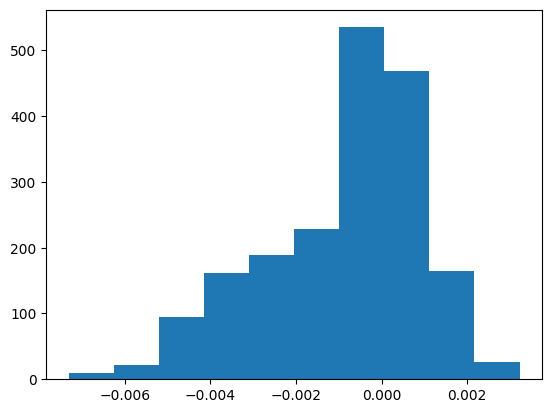

In [2]:
import matplotlib.pyplot as plt

train_means = [np.mean(input) for input in X_train]
max_mean = np.max(train_means)
print("Maximum mean: ", max_mean)

plt.hist(train_means)
plt.plot()

Maximum mean:  0.002631056


[]

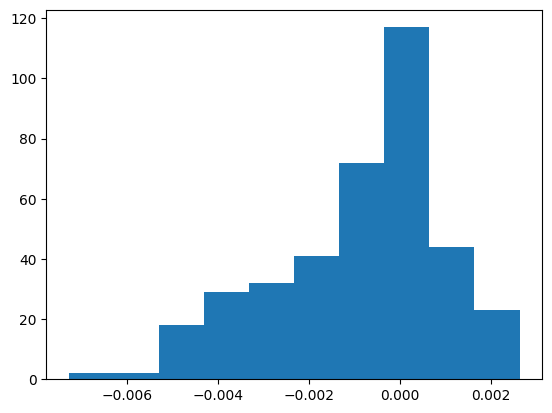

In [3]:
test_means = [np.mean(input) for input in X_test]
max_mean = np.max(test_means)
print("Maximum mean: ", max_mean)

plt.hist(test_means)
plt.plot()

In [4]:
# We generate random values according to the model. Then, we substract the global model weights from these values to obtain realistic inputs.
np.random.seed(42)
def generate_random_samples(shape, R=1e-3, n=40):
    assert n <= len(X_test_global)
    random_samples = []
    for i in range(0, n):
        random_model = np.random.uniform(low=-R, high=R, size=shape)
        global_model = X_test_global[i]
        delta = random_model - global_model
        random_samples.append(delta)
    return random_samples

def generate_random_data(shape, n_samples, R_values):
    random_data = []
    for R_value in R_values:
        random_data.append(generate_random_samples(shape, R_value, n=n_samples))
    return random_data

# Generate random samples (same shape as test set)
shape = X_test.shape[1]
print("Shape of one sample of the test set: ", shape)
n_samples = len(X_test_global)
print("Number of samples used per distribution: ", n_samples)

random_data = generate_random_data(shape, n_samples, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e1])
print("Random data used:")
for r in random_data:
    print(f"{r[0][:5]}")

Shape of one sample of the test set:  12810
Number of samples used per distribution:  38
Random data used:
[-0.0412524   0.09557696  0.04508556  0.02677254 -0.08273357]
[-0.00811809  0.01028789 -0.00169269  0.01535691 -0.01968319]
[-0.01616252  0.00521573 -0.0014379   0.00683983 -0.01437512]
[-0.01621249  0.00536943 -0.00128389  0.00696458 -0.01385682]
[-0.01615445  0.00542686 -0.00131026  0.00703917 -0.01394011]
[-0.01616077  0.00543369 -0.00131282  0.00704183 -0.01393708]
[-3.24713546 -4.20796601  7.54210058 -3.60520498  9.44180215]


In [5]:
# Function to retrieve a list of energies of random data
def get_random_energies(random_data, dagmm_model, gmm_params):
    energy_list = []
    for data in random_data:
        data_loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        energies = dagmm_model.compute_energies(data_loader, gmm_params)
        energy_list.append(energies)
    return energy_list

In [6]:
def train_dagmm(model, train_loader, num_epochs, lr=1e-3, lambda_energy=0.1, lambda_cov=0.005, device='cuda', print_info=True):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    i = 1
    for epoch in range(num_epochs):
        loss_info =  {
            "value": 0.0,
            "reconst": 0.0,
            "energy": 0.0,
            "cov_diag": 0.0,
        }

        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()

            loss, loss_dict = model.compute_loss(inputs, lambda_energy, lambda_cov)
            
            # Update weights
            loss.backward()
            optimizer.step()

            # record objective function
            loss_info["value"] += loss.item()
            loss_info["reconst"] += loss_dict["reconst"]
            loss_info["energy"] += loss_dict["energy"]
            loss_info["cov_diag"] += loss_dict["cov_diag"]

        loss_epoch = loss_info["value"] / len(train_loader)
        reconst_epoch = loss_info["reconst"] / len(train_loader)
        energy_epoch = lambda_energy * loss_info["energy"] / len(train_loader)
        cov_epoch = lambda_cov * loss_info["cov_diag"]/ len(train_loader)

        if (i <= 5 or i % 10 == 0) and print_info:
            print(
                    f"Epoch {epoch + 1}/{num_epochs}: \t\t"
                    + f"loss={loss_epoch:.6f} \t\t"
                    + f"reconst={reconst_epoch:.6f} "
                    + f"energy={energy_epoch:.6f} "
                    + f"cov_diag={cov_epoch:.6f}"
                )
        i += 1    

In [7]:
def eval_dagmm_model(dagmm_model, gmm_params):
    dagmm_model.eval()

    test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
    mean_test_energy = np.mean(test_energies)

    malicious_energies = dagmm_model.compute_energies(malicious_loader, gmm_params)

    random_energies_list = get_random_energies(random_data, dagmm_model, gmm_params)
    random_energies_lower_percentiles = []
    for random_energies in random_energies_list:
        # Get the 20th percentile of the random energies.
        random_energies_lower_percentiles.append(np.percentile(random_energies, 20))

    # Objective function of the grid search
    random_test_diffs = []
    for random_percentile in random_energies_lower_percentiles:
        random_test_diffs.append(random_percentile - mean_test_energy)

    # Use the percentile with the smallest energy. If this is higher than the mean energy of the test data, it is separable.
    min_rand_test_diff = np.min(random_test_diffs)

    # Use also the difference between the malicious energy (should be high) and test energy (should be low)
    malicious_percentile = np.percentile(malicious_energies, 25)
    test_mal_diff = malicious_percentile - mean_test_energy
    return min(min_rand_test_diff, test_mal_diff)

Hyperparameter Grid Search
---

In [8]:
from dagmm.dagmm.dagmm import DAGMM_Hyperparameters

from dagmm.delta_dagmm.delta_dagmm import DELTA_DAGMM
# Fixed Model settings
dimensions = [input_dim, 2048, 512, 128]
latent_dim = 32
estimation_hidden_size = 10

# Fixed Training settings
lambda_energy=0.1
lambda_cov=0.01

# 1. Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

epoch_params = [20]
n_gmm_params = [2]

print_info = True   # Whether or not to print the losses.

# Initialize with 0 - anything smaller will indicate a bad separation of test and random data.
best_score = 0
best_model = None
best_hyperparameters = None
best_gmm_params = None

for epoch_p in epoch_params:
    for n_gmm_p in n_gmm_params:
        parameters = {
            "epoch": epoch_p,
            "n_gmm": n_gmm_p
        }
        print(f"Using parameters:\t epoch={epoch_p}, n_gmm={n_gmm_p}")

        # Generate DAGMM_Hyperparameters
        hyperparameters = DAGMM_Hyperparameters(dimensions, latent_dim, estimation_hidden_size, n_gmm_p)

        # --- Train the model ---
        dagmm_model = DELTA_DAGMM(device, hyperparameters)
        train_dagmm(dagmm_model, train_loader, epoch_p, lambda_energy=lambda_energy, lambda_cov=lambda_cov, print_info=print_info)
        dagmm_model.eval()

        # Obtain gmm parameters
        gmm_params = dagmm_model.compute_gmm_params(train_loader)
        
        # --- Evaluate the model ---        
        # The difference between training and test data should be small (not that important, thus we ommit it)
        # and the energy value (lower x'th percentile) of the (closest) random data should be bigger than the mean energy of the test data (very important to be able to separate)
        # A negative score indicates that the random data could not be separated well from the test data.
        # A positive score indicates that the separation works (the higher the score, the better the separation!)
        score = eval_dagmm_model(dagmm_model, gmm_params)
        print(f"Obtained score: {score}")

        if score > best_score:
            best_score = score
            best_model = dagmm_model
            best_hyperparameters = hyperparameters
            best_gmm_params = gmm_params
            print(f"\t\t!!! New best model found !!!")

Using parameters:	 epoch=20, n_gmm=2
Epoch 1/20: 		loss=154462.671507 		reconst=0.006115 energy=3.548719 cov_diag=154459.116672
Epoch 2/20: 		loss=4686.167482 		reconst=0.039594 energy=3.984475 cov_diag=4682.143413
Epoch 3/20: 		loss=4577.345673 		reconst=0.084932 energy=4.030203 cov_diag=4573.230538
Epoch 4/20: 		loss=4556.932355 		reconst=0.131240 energy=4.050647 cov_diag=4552.750469
Epoch 5/20: 		loss=4541.368404 		reconst=0.175791 energy=4.066097 cov_diag=4537.126516
Epoch 10/20: 		loss=4541.154162 		reconst=0.464016 energy=4.087974 cov_diag=4536.602172
Epoch 20/20: 		loss=4491.951371 		reconst=0.925280 energy=4.081846 cov_diag=4486.944246
Obtained score: 49.324437155555216
		!!! New best model found !!!


/tmp/ipykernel_4029/2683175453.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data_loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)),


In [10]:
# Save everything
torch.save(best_model.state_dict(), "./dagmm/delta_dagmm/models/cifar10/10/model.pt")

for name, gmm_param in best_gmm_params.items():
    gmm_name = "./dagmm/delta_dagmm/models/cifar10/10/gmm_param_" + name + ".pt"
    torch.save(gmm_param, gmm_name)

# Store hyperparameters as a .yaml file
best_hyperparameters.save_params("./dagmm/delta_dagmm/models/cifar10/10/dagmm_hyperparameters.yaml")

Testing
===

In [11]:
from dagmm.dagmm.dagmm import DAGMM_Hyperparameters
from dagmm.delta_dagmm.delta_dagmm import DELTA_DAGMM
import torch
hyperparameters = DAGMM_Hyperparameters.load_params("./dagmm/delta_dagmm/models/cifar10/10/dagmm_hyperparameters.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dagmm_model = DELTA_DAGMM(device, hyperparameters)
dagmm_model.load_state_dict(torch.load("./dagmm/delta_dagmm/models/cifar10/10/model.pt", map_location=device))
dagmm_model.to(device)

DELTA_DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=12810, out_features=2048, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=2048, bias=True)
    (4): Tanh()
    (5): Linear(in_features=2048, out_features=12810, bias=True)
  )
  (estimation): Sequential(
    (0): Linear(in_features=35, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)

In [12]:
gmm_params = {}
gmm_params["mixture"] = torch.load("./dagmm/delta_dagmm/models/cifar10/10/gmm_param_mixture.pt")
gmm_params["mean"] = torch.load("./dagmm/delta_dagmm/models/cifar10/10/gmm_param_mean.pt")
gmm_params["cov"] = torch.load("./dagmm/delta_dagmm/models/cifar10/10/gmm_param_cov.pt")

In [13]:
train_energies = dagmm_model.compute_energies(train_loader, gmm_params)
test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
malicious_energies = dagmm_model.compute_energies(malicious_loader, gmm_params)
print("Mean of train energies: ", np.mean(train_energies))
print("Mean of test energies: ", np.mean(test_energies))
print("Mean of malicious energies: ", np.mean(malicious_energies))

Mean of train energies:  33.89728042846848
Mean of test energies:  25.680323004907255
Mean of malicious energies:  203.32286795211644


In [14]:
random_energies = get_random_energies(random_data, dagmm_model, gmm_params)
print("Mean of random energies (R=e-2): ", np.mean(random_energies[1]))

Mean of random energies (R=e-2):  838.6191087277246


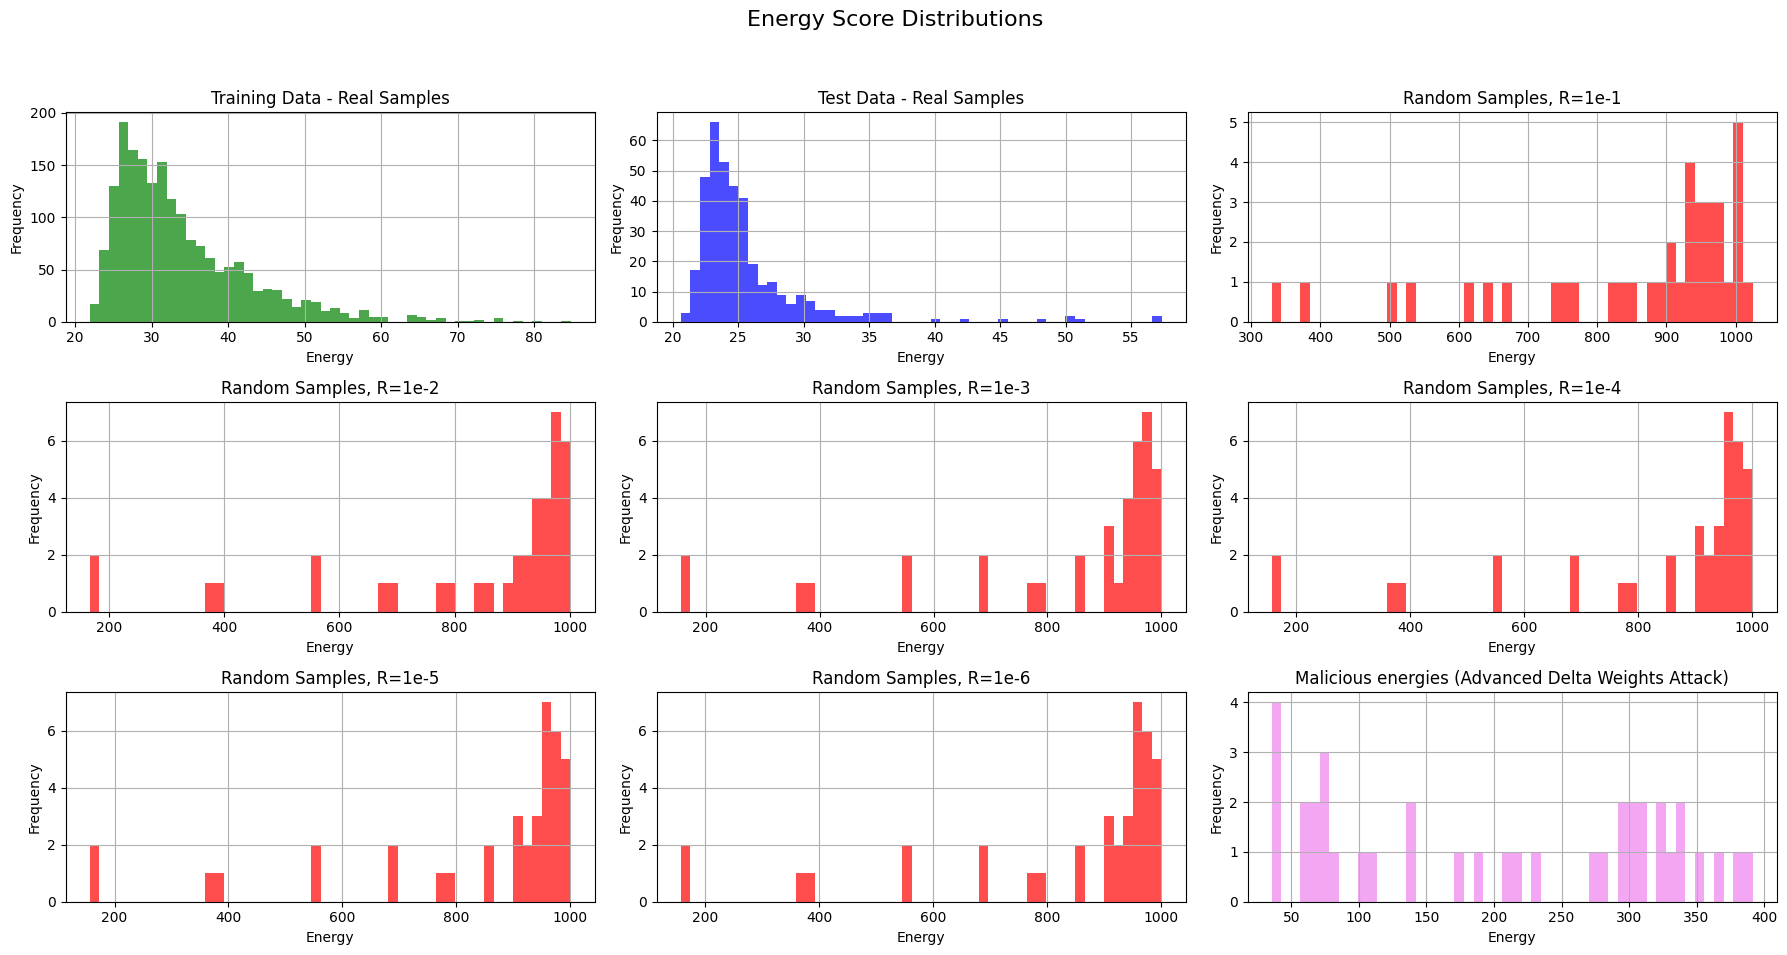

In [15]:
import matplotlib.pyplot as plt
# Plotting
# Plotting separate histograms
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle("Energy Score Distributions", fontsize=16)

# Plot 1: 
axes[0, 0].hist(train_energies, bins=50, alpha=0.7, color='green')
axes[0, 0].set_title("Training Data - Real Samples")
axes[0, 0].set_xlabel("Energy")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True)

# Plot 2: 
axes[0, 1].hist(test_energies, bins=50, alpha=0.7, color='blue')
axes[0, 1].set_title("Test Data - Real Samples")
axes[0, 1].set_xlabel("Energy")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True)

# Plot 3: 
axes[0, 2].hist(random_energies[0], bins=50, alpha=0.7, color='red')
axes[0, 2].set_title("Random Samples, R=1e-1")
axes[0, 2].set_xlabel("Energy")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].grid(True)

# Plot 4: 
axes[1, 0].hist(random_energies[1], bins=50, alpha=0.7, color='red')
axes[1, 0].set_title("Random Samples, R=1e-2")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True)

# Plot 5: 
axes[1, 1].hist(random_energies[2], bins=50, alpha=0.7, color='red')
axes[1, 1].set_title("Random Samples, R=1e-3")
axes[1, 1].set_xlabel("Energy")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True)

# Plot 6: 
axes[1, 2].hist(random_energies[3], bins=50, alpha=0.7, color='red')
axes[1, 2].set_title("Random Samples, R=1e-4")
axes[1, 2].set_xlabel("Energy")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].grid(True)

# Plot 7: 
axes[2, 0].hist(random_energies[4], bins=50, alpha=0.7, color='red')
axes[2, 0].set_title("Random Samples, R=1e-5")
axes[2, 0].set_xlabel("Energy")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].grid(True)

# Plot 8: 
axes[2, 1].hist(random_energies[5], bins=50, alpha=0.7, color='red')
axes[2, 1].set_title("Random Samples, R=1e-6")
axes[2, 1].set_xlabel("Energy")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True)

# Plot 9: 
axes[2, 2].hist(malicious_energies, bins=50, alpha=0.7, color='violet')
axes[2, 2].set_title("Malicious energies (Advanced Delta Weights Attack)")
axes[2, 2].set_xlabel("Energy")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].grid(True)
#axes[2, 2].set_xlim(-5, 5) # Adjust based on data

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [22]:
percentile = 95
threshold_percentile = np.percentile(test_energies, percentile)
print(f"{percentile} percentile is: {threshold_percentile:.4f}")
factor = 1.2
additional = 0.0
threshold = threshold_percentile * factor + additional

print(f"\nAnomaly Threshold (at {factor} * {percentile}th percentile of all energies): {threshold:.4f}")
print("99th percentile test energy: ", np.percentile(test_energies, 99))

95 percentile is: 34.1119

Anomaly Threshold (at 1.2 * 95th percentile of all energies): 40.9342
99th percentile test energy:  50.168158585219054


In [23]:
import yaml
threshold_dict = {
    'dagmm_threshold': float(threshold)
}

output_yaml_path = './dagmm/delta_dagmm/models/cifar10/10/dagmm_anomaly_threshold.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(threshold_dict, file, default_flow_style=False)

print(f"Anomaly threshold saved to '{output_yaml_path}'")

Anomaly threshold saved to './dagmm/delta_dagmm/models/cifar10/10/dagmm_anomaly_threshold.yaml'


In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def get_z_values(dataloader, dagmm_model):
    z_values = []
    for batch in dataloader:
        inputs = batch[0].to(device)

        _, latents, _ = dagmm_model.forward(inputs)
        z_values.append(latents)
    return torch.cat(z_values, dim=0).detach().cpu().numpy()

def pca_with_random_data(real_loaders, real_lables, random_data_list, dagmm_model):
    z_values_real = []
    for loader in real_loaders:
        z_values_real.append(get_z_values(loader, dagmm_model))

    labels = []
    z_values_random_list = []
    for i, rand_data in enumerate(random_data_list):
        random_dataloader = DataLoader(TensorDataset(torch.tensor(rand_data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        z = get_z_values(random_dataloader, dagmm_model)
        z_values_random_list.append(z)
        labels.append(f"Random_{i+1}")

    # Use PCA for 2D projection
    pca = PCA(n_components=2)
    z_real_2d = [pca.fit_transform(data) for data in z_values_real]
    z_random_2d = [pca.transform(data) for data in z_values_random_list]

    plt.figure(figsize=(8, 6))
    for data_2d, label in zip(z_real_2d, real_lables):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=label, alpha=0.6)

    for i, data_2d in enumerate(z_random_2d):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=labels[i], alpha=0.6)

    plt.title("PCA of Latent z-space")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

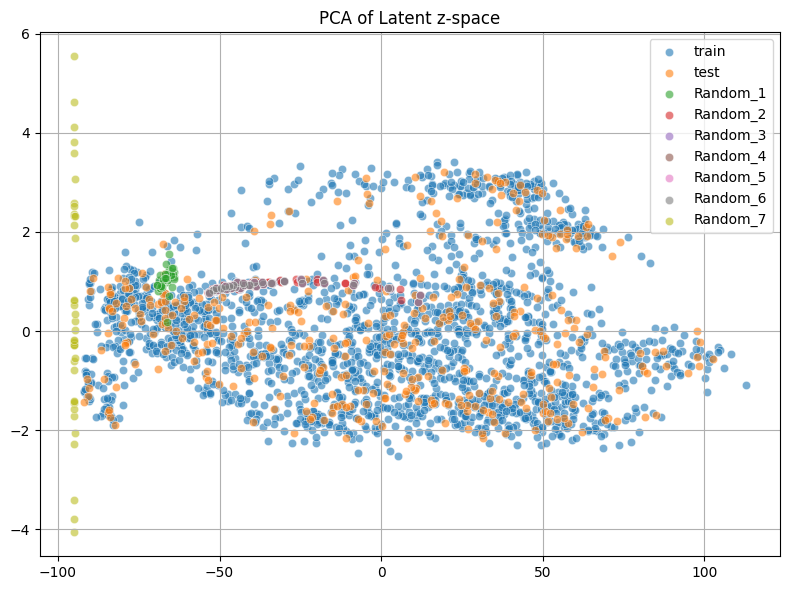

In [19]:
pca_with_random_data([train_loader, test_loader], ["train", "test"], random_data, dagmm_model)

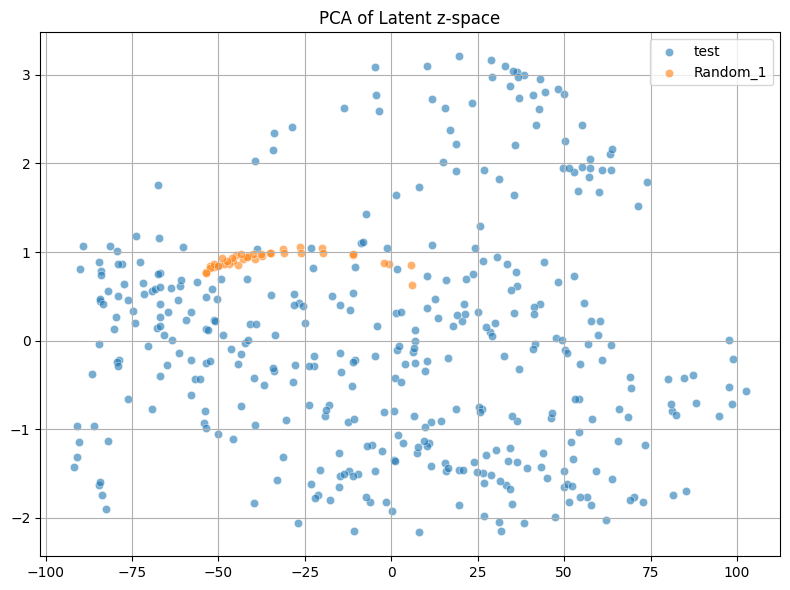

In [20]:
pca_with_random_data([test_loader], ["test"], [random_data[1]], dagmm_model)

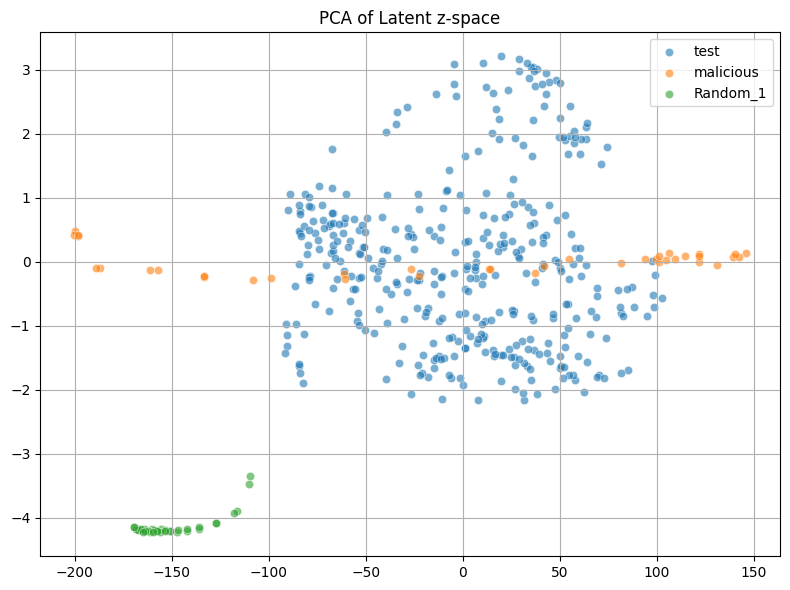

In [21]:
pca_with_random_data([test_loader, malicious_loader], ["test", "malicious"], [random_data[1]], dagmm_model)